In [1]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.nn import L1Loss
from torch.nn import init
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam

import warnings
warnings.filterwarnings('ignore')

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from rdkit import Chem
from rdkit.Chem import MACCSkeys, Descriptors
from rdkit.Chem.rdMolDescriptors import CalcNumRotatableBonds
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit import RDLogger  
RDLogger.DisableLog('rdApp.*')  

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head(3)

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN


In [6]:
def compute_rdkit_feats(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    features = {}
    
    maccs = MACCSkeys.GenMACCSKeys(mol)
    
    for i in range(1, maccs.GetNumBits()):  # bit 0 is always 1
        features[f'MACCS_{i}'] = int(maccs.GetBit(i))

    # Descriptors
    descs = {
        'MolWt': Descriptors.MolWt(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumValenceElectrons': Descriptors.NumValenceElectrons(mol),
        'NumHeavyAtoms': Descriptors.HeavyAtomCount(mol),
        'NumRings': Descriptors.RingCount(mol),
        'NumRotatableBonds': CalcNumRotatableBonds(mol),
        'MolLogP': Descriptors.MolLogP(mol),
        'MolMR': Descriptors.MolMR(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol)
    }
    features.update(descs)

    return features

In [7]:
maccs_data = []

for smile in tqdm(train['SMILES']):
    feats = compute_rdkit_feats(smile)
    if feats is None:
        maccs_data.append(None)
    else:
        maccs_data.append(feats)
        
maccs_df = pd.DataFrame(maccs_data)
train_rdkit = pd.concat([train, maccs_df], axis=1)

  0%|          | 0/7973 [00:00<?, ?it/s]

In [8]:
train_rdkit.head()

,id,SMILES,Tg,FFV,Tc,Density,Rg,MACCS_1,MACCS_2,MACCS_3,...,MolWt,TPSA,NumValenceElectrons,NumHeavyAtoms,NumRings,NumRotatableBonds,MolLogP,MolMR,NumHAcceptors,NumHDonors
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN,0,0,0,...,232.323,26.30,92,17,1,8,3.98170,68.4145,2,0
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN,0,0,0,...,598.919,24.06,236,45,5,16,12.35960,193.3954,2,2
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN,0,0,0,...,1003.207,122.27,364,73,10,15,14.21700,281.6006,9,0
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN,0,0,0,...,542.726,24.06,204,42,6,7,11.00768,179.8154,2,2
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN,0,0,0,...,965.154,182.28,376,70,6,34,11.84500,266.9958,14,0


In [9]:
class NeurIPSDS(Dataset):
    def __init__(self, df, feats, targ):
        self.X = df[feats].astype('float32').values
        self.y = df[targ].astype('float32').values
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [10]:
feat_cols = train_rdkit.columns.tolist()[7:]
targs = train_rdkit.columns.tolist()[2:7]
bs = 512

In [11]:
targs

['Tg', 'FFV', 'Tc', 'Density', 'Rg']

In [12]:
def get_dls(train_ds, val_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
                DataLoader(train_ds, batch_size=bs, shuffle=False, **kwargs))

In [13]:
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls[:2]
    
    @classmethod
    def dls(cls, train_ds, val_ds, bs, **kwargs):
        return cls(*get_dls(train_ds, val_ds, bs=bs, **kwargs))

In [14]:
def get_dataloaders(df, targ, batch_size=16):
    df2 = df.copy()
    df2 = df2[feat_cols + [targ]].dropna()
    scaler = StandardScaler()
    df2[feat_cols] = scaler.fit_transform(df2[feat_cols])
    
    # with open(os.path.join(save_dir, f'{target}_scaler.pkl'), 'wb') as f:
    #         pickle.dump(scaler, f)
    
    train_df, val_df = train_test_split(df2, test_size=0.2, random_state=42)
    
    train_ds = NeurIPSDS(train_df, feat_cols, targ)
    val_ds = NeurIPSDS(val_df, feat_cols, targ)
    
    dls = DataLoaders.dls(train_ds, val_ds, bs)
    
    return dls

In [15]:
def get_one_layer(inp_dim, out_dim, act=True):
    res = nn.Linear(inp_dim, out_dim)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def get_model():
    return nn.Sequential(
        get_one_layer(len(feat_cols), 128),
        get_one_layer(128, 64),
        get_one_layer(64,1,act=False)
    )

In [16]:
#torch.manual_seed(42)
model = get_model()

In [17]:
model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=176, out_features=128, bias=True)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=64, out_features=1, bias=True)
)

In [18]:
dls = get_dataloaders(train_rdkit, 'FFV')

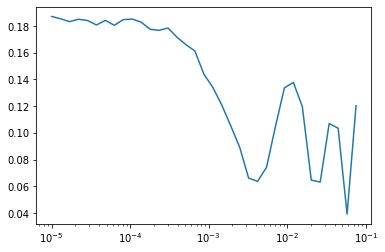

In [19]:
MomentumLearner(model, dls, F.l1_loss, cbs=[DeviceCB()]).lr_find()

In [20]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Linear
ReLU
Sequential
Linear
ReLU
Sequential
Linear
Sequential


In [21]:
def init_weights(m):
    if isinstance(m, (nn.Linear)): init.kaiming_normal_(m.weight)

In [22]:
model.apply(init_weights);

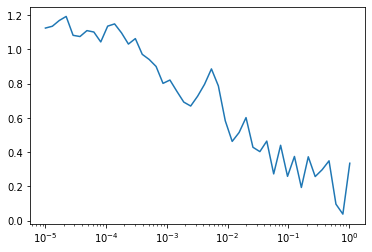

In [23]:
MomentumLearner(model, dls, F.l1_loss, cbs=[DeviceCB()]).lr_find()

In [24]:
class LossCB(Callback):
    def __init__(self): self.losses, self.epochs = [], []
    def after_epoch(self, learn):
        if not learn.training:
            self.losses.append(learn.loss.item())
            self.epochs.append(learn.epoch)
        print(learn.epoch, learn.loss.item(), 'train' if learn.training else 'eval')
    def after_fit(self, learn):
        plt.plot(self.epochs,self.losses)
        plt.xticks(ticks=self.epochs)

In [25]:
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), ProgressCB(plot=True), LossCB(), astats]

In [26]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.l1_loss, lr=8e-3, cbs=cbs)

0 0.42405039072036743 train
0 0.32211413979530334 eval
1 0.24208079278469086 train
1 0.19545301795005798 eval
2 0.15030185878276825 train
2 0.14502403140068054 eval


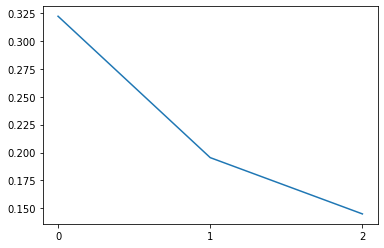

In [27]:
learn.fit(3)

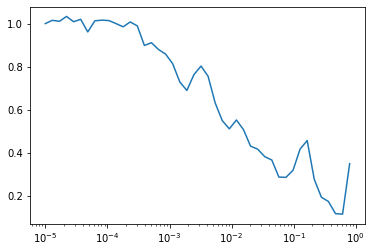

In [28]:
set_seed(42)
model = get_model()

for name, module in model.named_modules():
    if isinstance(module, nn.Linear):
        if module.out_features != 1:  # avoid output layer
            nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        else:
            nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
            
MomentumLearner(model, dls, F.l1_loss, cbs=[DeviceCB()]).lr_find()

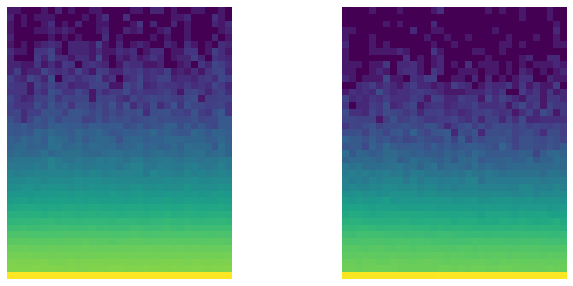

In [29]:
astats.color_dim()

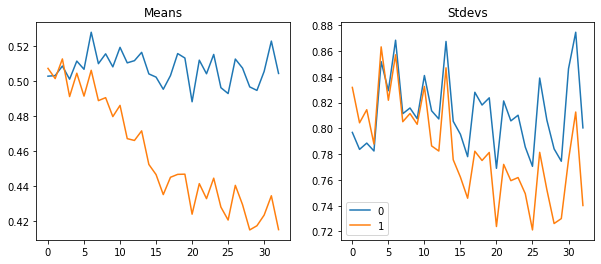

In [30]:
astats.plot_stats()

In [31]:
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([512, 176]), torch.Size([512]))

In [32]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.0040), tensor(1.0015))

In [33]:
get_model??

Signature: get_model()
Docstring: <no docstring>
Source:   
def get_model():
    return nn.Sequential(
        get_one_layer(len(feat_cols), 128),
        get_one_layer(128, 64),
        get_one_layer(64,1,act=False)
    )
File:      /tmp/ipykernel_8236/3814607028.py
Type:      function


In [34]:
get_one_layer??

Signature: get_one_layer(inp_dim, out_dim, act=True)
Docstring: <no docstring>
Source:   
def get_one_layer(inp_dim, out_dim, act=True):
    res = nn.Linear(inp_dim, out_dim)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res
File:      /tmp/ipykernel_8236/3814607028.py
Type:      function


In [35]:
def get_one_layer(ni, nf, act=nn.ReLU, norm=None, bias=None):
    if bias is None:
        bias = not (norm and issubclass(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)))
    layers = [nn.Linear(ni, nf, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [len(feat_cols), 512, 256, 128, 64, 32]
    layers = [get_one_layer(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, get_one_layer(nfs[-1], 1, act=None, norm=None, bias=True)).to(def_device)

In [36]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [37]:
from functools import partial

act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.BatchNorm1d))
cbs = [DeviceCB(), ProgressCB(plot=True), LossCB(), astats, hc]
iw = partial(init_weights, leaky=0.1)

In [38]:
model = get_model(act=act_gr, norm=nn.BatchNorm1d).apply(iw)

In [39]:
model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=176, out_features=512, bias=False)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (1): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (3): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (4): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  

0 0.1071489229798317 train
0 0.027891116216778755 eval
1 0.047155559062957764 train
1 0.03408713638782501 eval
2 0.029663236811757088 train
2 0.028493130579590797 eval
3 0.024301696568727493 train
3 0.024203093722462654 eval
4 0.022243596613407135 train
4 0.022829189896583557 eval
5 0.022108474746346474 train
5 0.022359924390912056 eval
6 0.020832838490605354 train
6 0.021824542433023453 eval
7 0.019794410094618797 train
7 0.02150462009012699 eval
8 0.01953990012407303 train
8 0.021230408921837807 eval
9 0.02263648621737957 train
9 0.021148860454559326 eval
10 0.02102147415280342 train
10 0.02106800675392151 eval
11 0.021180152893066406 train
11 0.021081823855638504 eval
12 0.021488163620233536 train
12 0.02103252522647381 eval
13 0.021117443218827248 train
13 0.02100166119635105 eval
14 0.020328495651483536 train
14 0.021033329889178276 eval
15 0.023353110998868942 train
15 0.021027980372309685 eval
16 0.020700572058558464 train
16 0.020973563194274902 eval
17 0.019779739901423454 tra

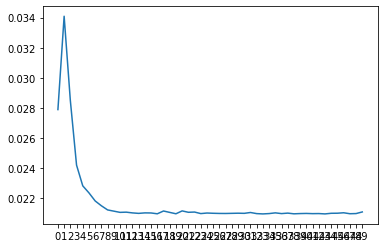

In [40]:
set_seed(42)
learn = MomentumLearner(model, dls, F.l1_loss, lr=1e-2, cbs=cbs)
learn.fit(50)

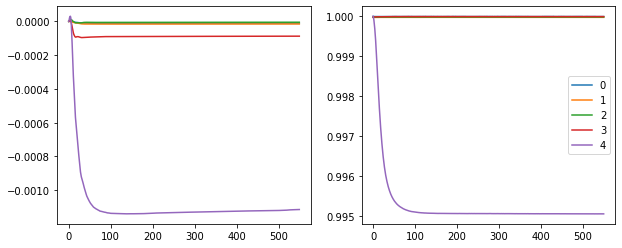

In [41]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(10));

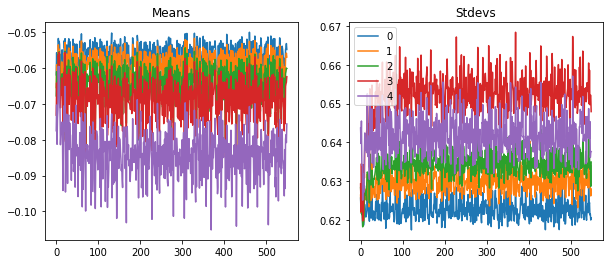

In [42]:
astats.plot_stats()

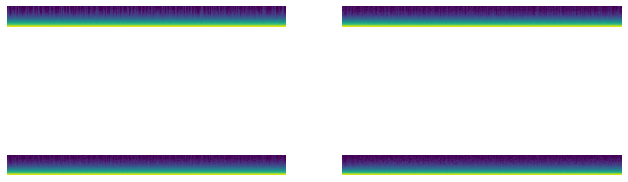

In [43]:
astats.color_dim()

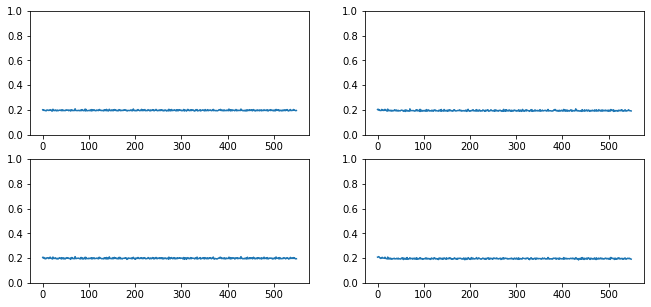

In [44]:
astats.dead_chart()